sentiment score  
comments  
Random forest 預測留言數量

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from glob import glob
import csv


第1欄 title  
第2到9欄（4正4負） sentiment score  
第10欄 positive/negative  
第11欄 留言數  
第12欄 label（判斷是否為極值）

判斷極值：每個情緒指標最高12.5分，若負向或正向其中一者超過5，則表示為極值，因此label為1

預測留言數：用test_x，產出 predict_y

給leo 2份csv，一份是test_data的文字編碼順序，一份是 test_y（真實y） & predict_y（預測值）

In [2]:
# 連動雲端硬碟
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 切割 title pos/neg
data = pd.read_csv('/content/drive/Shareddrives/Text Mining/CSV/Title_prediction/output_all_athelete.csv')

data['NEG'] = np.where(data['Prediction']=="neg", '1', '0')
data['POS'] = np.where(data['Prediction']=="pos", '1', '0')

data

,Title,Prediction,NEG,POS
0,[問卦]歐美中國舉重同量級無法超越台灣郭婞淳？,neg,1,0
1,[新聞] 世錦賽》「舉重女神」郭婞淳挺舉、總和,pos,0,1
2,[爆卦] 郭婞淳2021舉重世錦賽挺舉&總和金牌,pos,0,1
3,[問卦] 郭婞淳國語也太不標準了吧？,neg,1,0
4,[問卦] 如果郭婞淳的故事拍電影讓瑤瑤演可以嗎？,pos,0,1
...,...,...,...,...
428,[問卦] 楊勇緯身高167 會被台女嫌矮嗎？,neg,1,0
429,[問卦] 台中柔道館vs楊勇緯,neg,1,0
430,[新聞] 楊勇緯奪台灣第一面獎牌 蔡英文恭賀：,pos,0,1
431,[問卦] 高藤直壽幹嘛把楊勇緯的手手舉起來？,neg,1,0


In [4]:
# import keymoji scores into dataframe

keymoji_all = glob('/content/drive/Shareddrives/Text Mining/CSV/Keymoji/KeyMoji_score_*.csv')
#keymoji_all = glob('/content/drive/MyDrive/Colab Notebooks/final/csv/Keymoji/KeyMoji_score_*.csv')
print(keymoji_all)


df_key_all = pd.DataFrame()

for filename in keymoji_all:
  df = pd.read_csv(filename, header=0, index_col=0)
  df_key_all = pd.concat([df_key_all, df], axis=0)

df_key_all = df_key_all.reset_index(drop=True)
df_key_all

['/content/drive/Shareddrives/Text Mining/CSV/Keymoji/KeyMoji_score_GUO.csv', '/content/drive/Shareddrives/Text Mining/CSV/Keymoji/KeyMoji_score_YANG.csv', '/content/drive/Shareddrives/Text Mining/CSV/Keymoji/KeyMoji_score_LEE.csv', '/content/drive/Shareddrives/Text Mining/CSV/Keymoji/KeyMoji_score_LIN.csv', '/content/drive/Shareddrives/Text Mining/CSV/Keymoji/KeyMoji_score_TAI.csv']


,Title,Anger,Anticipation,Disgust,Fear,Joy,Sadness,Surprise,Trust
0,問卦歐美中國舉重同量級無法超越台灣郭婞淳,2.4902,0.5397,12.5000,0.5853,0.5593,2.3929,0.5058,0.5238
1,新聞世錦賽舉重女神郭婞淳挺舉總和,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,爆卦郭婞淳2021舉重世錦賽挺舉總和金牌,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,問卦郭婞淳國語也太不標準了吧,0.2071,0.7107,0.2502,0.0500,0.5348,0.2662,0.2890,0.5320
4,問卦如果郭婞淳的故事拍電影讓瑤瑤演可以嗎,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...
428,新聞陳其邁暖迎戴資穎讓她吃好睡好小,0.4321,0.8954,0.0990,0.2308,3.0642,0.8822,2.0326,2.2016
429,問卦戴資穎受訪的時候要問他什麼,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
430,新聞戴資穎深夜罕見動怒被批沒奪金失誤,0.4184,0.3327,0.4360,0.4340,0.3128,0.4940,0.4748,0.3760
431,新聞戴資穎返台罕見說重話回文站在場上,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


In [5]:
# merge原本的df跟keymoji
data_all = pd.merge(data, df_key_all, how='outer', left_index=True, right_index=True)
print(data_all)

# Title_y改名Title
data_all = data_all.rename(columns={'Title_y' : 'Title'})

# drop有符號的title_x
data_all = data_all.drop(columns=['Title_x'])

# 重新排序col name順序
data_all = data_all[['Title', 'Prediction', 'NEG', 'POS', 'Trust', 'Joy', 'Surprise', 'Anticipation', 'Fear', 'Anger', 'Disgust', 'Sadness']]
data_all


                            Title_x Prediction NEG POS               Title_y  \
0    [問卦]歐美中國舉重同量級無法超越台灣郭婞淳？               neg   1   0  問卦歐美中國舉重同量級無法超越台灣郭婞淳   
1    [新聞] 世錦賽》「舉重女神」郭婞淳挺舉、總和               pos   0   1      新聞世錦賽舉重女神郭婞淳挺舉總和   
2    [爆卦] 郭婞淳2021舉重世錦賽挺舉&總和金牌              pos   0   1  爆卦郭婞淳2021舉重世錦賽挺舉總和金牌   
3    [問卦] 郭婞淳國語也太不標準了吧？                    neg   1   0        問卦郭婞淳國語也太不標準了吧   
4    [問卦] 如果郭婞淳的故事拍電影讓瑤瑤演可以嗎？              pos   0   1  問卦如果郭婞淳的故事拍電影讓瑤瑤演可以嗎   
..                              ...        ...  ..  ..                   ...   
428  [問卦] 楊勇緯身高167 會被台女嫌矮嗎？                neg   1   0     新聞陳其邁暖迎戴資穎讓她吃好睡好小   
429  [問卦] 台中柔道館vs楊勇緯                       neg   1   0       問卦戴資穎受訪的時候要問他什麼   
430  [新聞] 楊勇緯奪台灣第一面獎牌　蔡英文恭賀：               pos   0   1    新聞戴資穎深夜罕見動怒被批沒奪金失誤   
431  [問卦] 高藤直壽幹嘛把楊勇緯的手手舉起來？                neg   1   0    新聞戴資穎返台罕見說重話回文站在場上   
432  [新聞] 「讓世界看見台灣柔道」楊勇緯：我要的               pos   0   1    新聞幻象伴飛戴資穎麟洋配蔡壁如發文誤   

      Anger  Anticipation  Disgust    F

,Title,Prediction,NEG,POS,Trust,Joy,Surprise,Anticipation,Fear,Anger,Disgust,Sadness
0,問卦歐美中國舉重同量級無法超越台灣郭婞淳,neg,1,0,0.5238,0.5593,0.5058,0.5397,0.5853,2.4902,12.5000,2.3929
1,新聞世錦賽舉重女神郭婞淳挺舉總和,pos,0,1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,爆卦郭婞淳2021舉重世錦賽挺舉總和金牌,pos,0,1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,問卦郭婞淳國語也太不標準了吧,neg,1,0,0.5320,0.5348,0.2890,0.7107,0.0500,0.2071,0.2502,0.2662
4,問卦如果郭婞淳的故事拍電影讓瑤瑤演可以嗎,pos,0,1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...
428,新聞陳其邁暖迎戴資穎讓她吃好睡好小,neg,1,0,2.2016,3.0642,2.0326,0.8954,0.2308,0.4321,0.0990,0.8822
429,問卦戴資穎受訪的時候要問他什麼,neg,1,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
430,新聞戴資穎深夜罕見動怒被批沒奪金失誤,pos,0,1,0.3760,0.3128,0.4748,0.3327,0.4340,0.4184,0.4360,0.4940
431,新聞戴資穎返台罕見說重話回文站在場上,neg,1,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


In [6]:
# 判斷是否為極值
# 每個情緒指標最高12.5分，若負向或正向其中一者超過5，則表示為極值，因此label為1
pos_sum = data_all["Trust"] + data_all["Joy"] + data_all["Surprise"] + data_all["Anticipation"]
neg_sum = data_all["Fear"] + data_all["Anger"] + data_all["Sadness"] + data_all["Disgust"]

# print(np.mean(pos_sum)) = 5.289057505773668
# print(np.mean(neg_sum)) = 4.238909699769053

data_all['IS_EXTREME'] = np.where((pos_sum>5) | (neg_sum>5), '1', '0')
data_all

,Title,Prediction,NEG,POS,Trust,Joy,Surprise,Anticipation,Fear,Anger,Disgust,Sadness,IS_EXTREME
0,問卦歐美中國舉重同量級無法超越台灣郭婞淳,neg,1,0,0.5238,0.5593,0.5058,0.5397,0.5853,2.4902,12.5000,2.3929,1
1,新聞世錦賽舉重女神郭婞淳挺舉總和,pos,0,1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0
2,爆卦郭婞淳2021舉重世錦賽挺舉總和金牌,pos,0,1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0
3,問卦郭婞淳國語也太不標準了吧,neg,1,0,0.5320,0.5348,0.2890,0.7107,0.0500,0.2071,0.2502,0.2662,0
4,問卦如果郭婞淳的故事拍電影讓瑤瑤演可以嗎,pos,0,1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
428,新聞陳其邁暖迎戴資穎讓她吃好睡好小,neg,1,0,2.2016,3.0642,2.0326,0.8954,0.2308,0.4321,0.0990,0.8822,1
429,問卦戴資穎受訪的時候要問他什麼,neg,1,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0
430,新聞戴資穎深夜罕見動怒被批沒奪金失誤,pos,0,1,0.3760,0.3128,0.4748,0.3327,0.4340,0.4184,0.4360,0.4940,0
431,新聞戴資穎返台罕見說重話回文站在場上,neg,1,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0


In [7]:
# 把 comment num csv 轉成df的一個column

files = glob('/content/drive/MyDrive/Colab Notebooks/final/csv/comments_num_output_*.csv')
print(files)

#csv寫法
all_comments_num = []

for filename in files:
  with open(filename, newline='') as f:
    reader = csv.reader(f)
    all_comments_num = all_comments_num + list(reader)[0]

print(len(all_comments_num))

#pandas寫法
# df_comments = pd.DataFrame()

# for filename in files:
#   df = pd.read_csv(filename, header=None)
#   df_comments = pd.concat([df_comments, df], axis=1)

# print(df_comments)


# df_comments_T = df_comments.T
# df_comments_T = df_comments_T.reset_index(drop=True)
# df_comments_T.columns=['comments']
# print(df_comments_T)

['/content/drive/MyDrive/Colab Notebooks/final/csv/comments_num_output_GUO.csv', '/content/drive/MyDrive/Colab Notebooks/final/csv/comments_num_output_LEE.csv', '/content/drive/MyDrive/Colab Notebooks/final/csv/comments_num_output_LIN.csv', '/content/drive/MyDrive/Colab Notebooks/final/csv/comments_num_output_TAI.csv', '/content/drive/MyDrive/Colab Notebooks/final/csv/comments_num_output_YANG.csv']
433


In [8]:
# data_all = pd.merge(data, df1, how='outer', left_index=True, right_index=True)
data_all['comments'] = all_comments_num
data_all

,Title,Prediction,NEG,POS,Trust,Joy,Surprise,Anticipation,Fear,Anger,Disgust,Sadness,IS_EXTREME,comments
0,問卦歐美中國舉重同量級無法超越台灣郭婞淳,neg,1,0,0.5238,0.5593,0.5058,0.5397,0.5853,2.4902,12.5000,2.3929,1,13
1,新聞世錦賽舉重女神郭婞淳挺舉總和,pos,0,1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,16
2,爆卦郭婞淳2021舉重世錦賽挺舉總和金牌,pos,0,1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,143
3,問卦郭婞淳國語也太不標準了吧,neg,1,0,0.5320,0.5348,0.2890,0.7107,0.0500,0.2071,0.2502,0.2662,0,69
4,問卦如果郭婞淳的故事拍電影讓瑤瑤演可以嗎,pos,0,1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428,新聞陳其邁暖迎戴資穎讓她吃好睡好小,neg,1,0,2.2016,3.0642,2.0326,0.8954,0.2308,0.4321,0.0990,0.8822,1,191
429,問卦戴資穎受訪的時候要問他什麼,neg,1,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,11
430,新聞戴資穎深夜罕見動怒被批沒奪金失誤,pos,0,1,0.3760,0.3128,0.4748,0.3327,0.4340,0.4184,0.4360,0.4940,0,303
431,新聞戴資穎返台罕見說重話回文站在場上,neg,1,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,30


In [9]:
data_all.to_csv('/content/drive/Shareddrives/Text Mining/CSV/temp_keymoji_K/small_data.csv')

In [10]:
# RF train
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(data_all.drop(columns=['Title', 'Prediction', 'comments'], axis=1), data_all[['comments']], test_size=0.33, random_state=42)

# Label_Encoder
labelencoder = LabelEncoder()
columns = ['NEG', 'POS','Trust', 'Joy', 'Surprise', 'Anticipation', 'Fear', 'Anger', 'Disgust', 'Sadness', 'IS_EXTREME']
for col_name in columns: 
    train_x[col_name] = labelencoder.fit_transform(train_x[col_name])

In [11]:
train_x

,NEG,POS,Trust,Joy,Surprise,Anticipation,Fear,Anger,Disgust,Sadness,IS_EXTREME
109,0,1,69,59,65,64,42,49,50,62,1
196,1,0,0,0,0,0,0,0,0,0,0
145,0,1,16,5,11,1,49,43,26,37,0
199,1,0,0,0,0,0,0,0,0,0,0
327,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
71,0,1,0,0,0,0,0,0,0,0,0
106,1,0,42,47,47,8,82,84,83,84,1
270,0,1,0,0,0,0,0,0,0,0,0
348,0,1,44,6,24,27,81,79,81,74,1


In [12]:
train_y

,comments
109,13
196,12
145,3
199,48
327,64
...,...
71,16
106,11
270,81
348,87


In [13]:
test_x

,NEG,POS,Trust,Joy,Surprise,Anticipation,Fear,Anger,Disgust,Sadness,IS_EXTREME
425,0,1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0
75,0,1,5.9788,8.4453,8.0968,7.0263,0.9599,1.3461,0.7851,2.3931,1
181,1,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0
30,1,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0
364,1,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0
...,...,...,...,...,...,...,...,...,...,...,...
386,0,1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0
318,1,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0
218,1,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0
338,0,1,6.3877,8.3266,7.5942,7.2969,0.0940,0.7638,0.2988,1.5347,1


In [14]:
test_y

,comments
425,113
75,12
181,21
30,13
364,23
...,...
386,107
318,27
218,133
338,227


In [15]:
from sklearn.ensemble import RandomForestRegressor

# 建立RandomForestRegressor模型
randomForestModel = RandomForestRegressor(n_estimators=100, random_state=42)
# 使用訓練資料訓練模型
randomForestModel.fit(train_x, train_y.values.ravel().astype(np.float64))
# 使用訓練資料預測
predictions = randomForestModel.predict(test_x)
# Calculate the absolute errors
errors = abs(predictions - test_y.values.ravel().astype(np.float64))
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 71.45 degrees.


In [16]:
features = train_x.columns.to_list()
feature_importances = randomForestModel.feature_importances_
forest_importances = pd.Series(feature_importances, index=features).sort_values(ascending=False)
print("The firstly important features is: ", forest_importances.index[0])
print("The secondly important features is: ", forest_importances.index[1])
print("The thirdly important features is: ", forest_importances.index[2])

The firstly important features is:  Fear
The secondly important features is:  Anger
The thirdly important features is:  Sadness


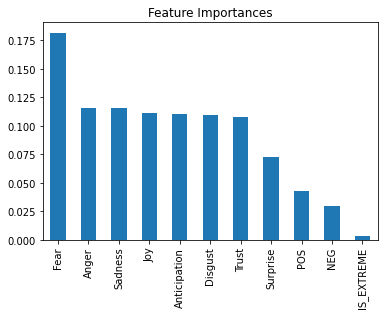

In [17]:
forest_importances.plot.bar()
plt.title('Feature Importances')
plt.show()

In [18]:
# 每個運動員的雷達圖

import numpy as np
import matplotlib.pyplot as plt
# 用於正常顯示中文
plt.rcParams['font.sans-serif'] = 'SimHei'
#用於正常顯示符號
plt.rcParams['axes.unicode_minus'] = False

# 使用ggplot的繪圖風格，這個類似於美化了，可以通過plt.style.available查看可選值，你會發現其它的風格真的醜。。。
plt.style.use('ggplot')

# 各運動員的 keymoji
col_list = ['Trust', 'Joy', 'Surprise', 'Anticipation', 'Fear', 'Anger', 'Disgust', 'Sadness']
keymoji_guo = pd.read_csv('/content/drive/Shareddrives/Text Mining/CSV/Keymoji/KeyMoji_score_GUO.csv', usecols=col_list)
key_list_guo = [np.mean(keymoji_guo["Trust"]), np.mean(keymoji_guo["Joy"]), np.mean(keymoji_guo["Surprise"]), np.mean(keymoji_guo["Anticipation"]), np.mean(keymoji_guo["Fear"]), np.mean(keymoji_guo["Anger"]), np.mean(keymoji_guo["Disgust"]), np.mean(keymoji_guo["Sadness"])]
print(key_list_guo)

keymoji_lee = pd.read_csv('/content/drive/Shareddrives/Text Mining/CSV/Keymoji/KeyMoji_score_LEE.csv', usecols=col_list)
key_list_lee = [np.mean(keymoji_lee["Trust"]), np.mean(keymoji_lee["Joy"]), np.mean(keymoji_lee["Surprise"]), np.mean(keymoji_lee["Anticipation"]), np.mean(keymoji_lee["Fear"]), np.mean(keymoji_lee["Anger"]), np.mean(keymoji_lee["Disgust"]), np.mean(keymoji_lee["Sadness"])]
print(key_list_lee)

keymoji_lin = pd.read_csv('/content/drive/Shareddrives/Text Mining/CSV/Keymoji/KeyMoji_score_LIN.csv', usecols=col_list)
key_list_lin = [np.mean(keymoji_lin["Trust"]), np.mean(keymoji_lin["Joy"]), np.mean(keymoji_lin["Surprise"]), np.mean(keymoji_lin["Anticipation"]), np.mean(keymoji_lin["Fear"]), np.mean(keymoji_lin["Anger"]), np.mean(keymoji_lin["Disgust"]), np.mean(keymoji_lin["Sadness"])]
print(key_list_lin)

keymoji_tai = pd.read_csv('/content/drive/Shareddrives/Text Mining/CSV/Keymoji/KeyMoji_score_TAI.csv', usecols=col_list)
key_list_tai = [np.mean(keymoji_tai["Trust"]), np.mean(keymoji_tai["Joy"]), np.mean(keymoji_tai["Surprise"]), np.mean(keymoji_tai["Anticipation"]), np.mean(keymoji_tai["Fear"]), np.mean(keymoji_tai["Anger"]), np.mean(keymoji_tai["Disgust"]), np.mean(keymoji_tai["Sadness"])]
print(key_list_tai)

keymoji_yang = pd.read_csv('/content/drive/Shareddrives/Text Mining/CSV/Keymoji/KeyMoji_score_YANG.csv', usecols=col_list)
key_list_yang = [np.mean(keymoji_yang["Trust"]), np.mean(keymoji_yang["Joy"]), np.mean(keymoji_yang["Surprise"]), np.mean(keymoji_yang["Anticipation"]), np.mean(keymoji_yang["Fear"]), np.mean(keymoji_yang["Anger"]), np.mean(keymoji_yang["Disgust"]), np.mean(keymoji_yang["Sadness"])]
print(key_list_yang)

[1.3223550000000006, 1.2957460000000005, 1.2814030000000003, 1.2468260000000004, 0.4617349999999999, 0.565953, 0.5747830000000003, 0.7167309999999999]
[1.7443060606060607, 2.0634878787878788, 2.0668151515151507, 1.8659121212121212, 0.3747484848484848, 0.492039393939394, 0.5157393939393938, 0.6899969696969697]
[1.235768000000001, 1.2791820000000003, 1.395776, 1.1266770000000006, 1.289103, 1.4215510000000002, 1.4625770000000002, 1.4904519999999999]
[1.2679820000000002, 1.3298090000000002, 1.2987629999999997, 1.1930650000000003, 0.8942620000000001, 0.9204850000000003, 0.9025900000000001, 1.0537710000000002]
[1.2066230000000002, 1.3481299999999996, 1.4705290000000002, 1.0486129999999994, 1.4052810000000002, 1.4188139999999996, 1.4011990000000003, 1.6912589999999996]


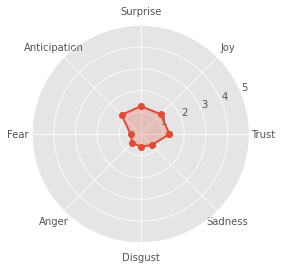

In [42]:
# 構造數據
# GUO
values = key_list_guo
feature = ['Trust','Joy','Surprise','Anticipation','Fear', 'Anger', 'Disgust', 'Sadness']

# 設置每個數據點的顯示位置，在雷達圖上用角度表示
angles=np.linspace(0, 2*np.pi, len(values), endpoint=False)

# 拼接數據首尾，使圖形中線條封閉
values=np.concatenate((values,[values[0]]))
angles=np.concatenate((angles,[angles[0]]))

# 繪圖
fig=plt.figure()
# 設置爲極座標格式
ax = fig.add_subplot(111, polar=True)
# 繪製折線圖
ax.plot(angles, values, 'o-', linewidth=2)
# 填充顏色
ax.fill(angles, values, alpha=0.25)

# 設置圖標上的角度劃分刻度，爲每個數據點處添加標籤
ax.set_thetagrids(angles * 180/np.pi, feature)

# 設置雷達圖的範圍
ax.set_ylim(0,5)
# 添加標題
#plt.title('GUO Keymoji')
# 添加網格線
ax.grid(True)

plt.show()

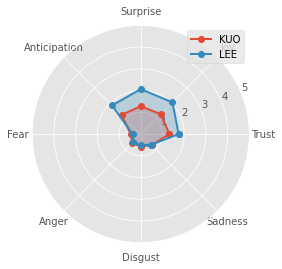

In [43]:
# LEE
values_2 = key_list_lee
values_2 = np.concatenate([values_2,[values_2[0]]])

fig = plt.figure()
ax = fig.add_subplot(111, polar=True)
ax.plot(angles, values, 'o-', linewidth=2,label='KUO')
ax.fill(angles, values, alpha=0.25)

ax.plot(angles, values_2, 'o-', linewidth=2,label='LEE')
ax.fill(angles, values_2, alpha=0.25)

ax.set_thetagrids(angles * 180/np.pi, feature)
ax.set_ylim(0,5)
#plt.title('Keymoji of different athletes')
plt.legend(loc='best')
ax.grid(True)
plt.show()

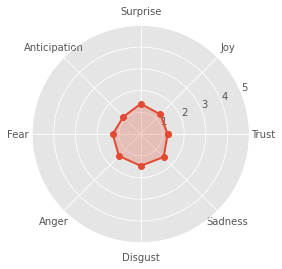

In [44]:
# LIN
values = key_list_lin
feature = ['Trust','Joy','Surprise','Anticipation','Fear', 'Anger', 'Disgust', 'Sadness']

# 設置每個數據點的顯示位置，在雷達圖上用角度表示
angles=np.linspace(0, 2*np.pi, len(values), endpoint=False)

# 拼接數據首尾，使圖形中線條封閉
values=np.concatenate((values,[values[0]]))
angles=np.concatenate((angles,[angles[0]]))

# 繪圖
fig=plt.figure()
# 設置爲極座標格式
ax = fig.add_subplot(111, polar=True)
# 繪製折線圖
ax.plot(angles, values, 'o-', linewidth=2)
# 填充顏色
ax.fill(angles, values, alpha=0.25)

# 設置圖標上的角度劃分刻度，爲每個數據點處添加標籤
ax.set_thetagrids(angles * 180/np.pi, feature)

# 設置雷達圖的範圍
ax.set_ylim(0,5)
# 添加標題
#plt.title('GUO Keymoji')
# 添加網格線
ax.grid(True)

plt.show()

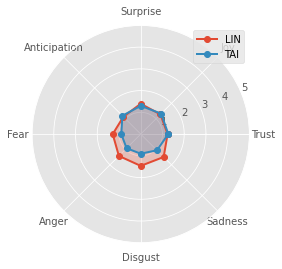

In [46]:
# TAI
values_2 = key_list_tai
values_2 = np.concatenate([values_2,[values_2[0]]])

fig = plt.figure()
ax = fig.add_subplot(111, polar=True)
ax.plot(angles, values, 'o-', linewidth=2,label='LIN')
ax.fill(angles, values, alpha=0.25)

ax.plot(angles, values_2, 'o-', linewidth=2,label='TAI')
ax.fill(angles, values_2, alpha=0.25)

ax.set_thetagrids(angles * 180/np.pi, feature)
ax.set_ylim(0,5)
#plt.title('Keymoji of different athletes')
plt.legend(loc='best')
ax.grid(True)
plt.show()

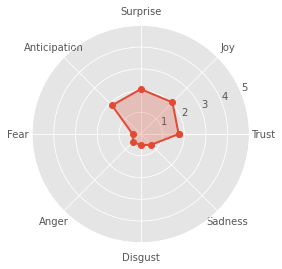

In [39]:
# LEE
values = key_list_lee
feature = ['Trust','Joy','Surprise','Anticipation','Fear', 'Anger', 'Disgust', 'Sadness']

# 設置每個數據點的顯示位置，在雷達圖上用角度表示
angles=np.linspace(0, 2*np.pi, len(values), endpoint=False)

# 拼接數據首尾，使圖形中線條封閉
values=np.concatenate((values,[values[0]]))
angles=np.concatenate((angles,[angles[0]]))

# 繪圖
fig=plt.figure()
# 設置爲極座標格式
ax = fig.add_subplot(111, polar=True)
# 繪製折線圖
ax.plot(angles, values, 'o-', linewidth=2)
# 填充顏色
ax.fill(angles, values, alpha=0.25)

# 設置圖標上的角度劃分刻度，爲每個數據點處添加標籤
ax.set_thetagrids(angles * 180/np.pi, feature)

# 設置雷達圖的範圍
ax.set_ylim(0,5)
# 添加標題
#plt.title('GUO Keymoji')
# 添加網格線
ax.grid(True)

plt.show()

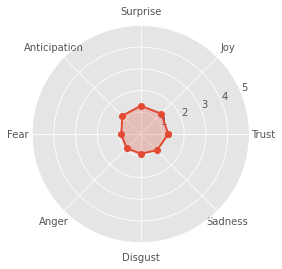

In [40]:
# TAI
values = key_list_tai
feature = ['Trust','Joy','Surprise','Anticipation','Fear', 'Anger', 'Disgust', 'Sadness']

# 設置每個數據點的顯示位置，在雷達圖上用角度表示
angles=np.linspace(0, 2*np.pi, len(values), endpoint=False)

# 拼接數據首尾，使圖形中線條封閉
values=np.concatenate((values,[values[0]]))
angles=np.concatenate((angles,[angles[0]]))

# 繪圖
fig=plt.figure()
# 設置爲極座標格式
ax = fig.add_subplot(111, polar=True)
# 繪製折線圖
ax.plot(angles, values, 'o-', linewidth=2)
# 填充顏色
ax.fill(angles, values, alpha=0.25)

# 設置圖標上的角度劃分刻度，爲每個數據點處添加標籤
ax.set_thetagrids(angles * 180/np.pi, feature)

# 設置雷達圖的範圍
ax.set_ylim(0,5)
# 添加標題
#plt.title('GUO Keymoji')
# 添加網格線
ax.grid(True)

plt.show()

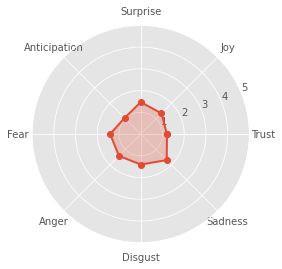

In [41]:
# YANG
values = key_list_yang
feature = ['Trust','Joy','Surprise','Anticipation','Fear', 'Anger', 'Disgust', 'Sadness']

# 設置每個數據點的顯示位置，在雷達圖上用角度表示
angles=np.linspace(0, 2*np.pi, len(values), endpoint=False)

# 拼接數據首尾，使圖形中線條封閉
values=np.concatenate((values,[values[0]]))
angles=np.concatenate((angles,[angles[0]]))

# 繪圖
fig=plt.figure()
# 設置爲極座標格式
ax = fig.add_subplot(111, polar=True)
# 繪製折線圖
ax.plot(angles, values, 'o-', linewidth=2)
# 填充顏色
ax.fill(angles, values, alpha=0.25)

# 設置圖標上的角度劃分刻度，爲每個數據點處添加標籤
ax.set_thetagrids(angles * 180/np.pi, feature)

# 設置雷達圖的範圍
ax.set_ylim(0,5)
# 添加標題
#plt.title('GUO Keymoji')
# 添加網格線
ax.grid(True)

plt.show()

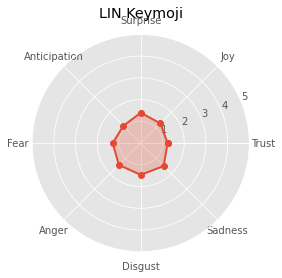

In [21]:
# LIN
values = key_list_lin
feature = ['Trust','Joy','Surprise','Anticipation','Fear', 'Anger', 'Disgust', 'Sadness']

# 設置每個數據點的顯示位置，在雷達圖上用角度表示
angles = np.linspace(0, 2*np.pi, len(values), endpoint=False)

# 拼接數據首尾，使圖形中線條封閉
values = np.concatenate((values,[values[0]]))
angles = np.concatenate((angles,[angles[0]]))

# 繪圖
fig = plt.figure()
# 設置爲極座標格式
ax = fig.add_subplot(111, polar=True)
# 繪製折線圖
ax.plot(angles, values, 'o-', linewidth=2)
# 填充顏色
ax.fill(angles, values, alpha=0.25)

# 設置圖標上的角度劃分刻度，爲每個數據點處添加標籤
ax.set_thetagrids(angles * 180/np.pi, feature)

# 設置雷達圖的範圍
ax.set_ylim(0,5)
# 添加標題
plt.title('LIN Keymoji')
# 添加網格線
ax.grid(True)

plt.show()

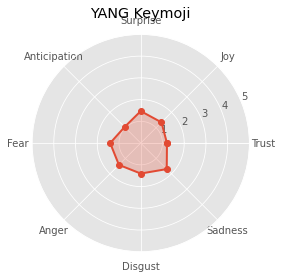

In [23]:
# YANG
values = key_list_yang
feature = ['Trust','Joy','Surprise','Anticipation','Fear', 'Anger', 'Disgust', 'Sadness']

# 設置每個數據點的顯示位置，在雷達圖上用角度表示
angles = np.linspace(0, 2*np.pi, len(values), endpoint=False)

# 拼接數據首尾，使圖形中線條封閉
values = np.concatenate((values,[values[0]]))
angles = np.concatenate((angles,[angles[0]]))

# 繪圖
fig = plt.figure()
# 設置爲極座標格式
ax = fig.add_subplot(111, polar=True)
# 繪製折線圖
ax.plot(angles, values, 'o-', linewidth=2)
# 填充顏色
ax.fill(angles, values, alpha=0.25)

# 設置圖標上的角度劃分刻度，爲每個數據點處添加標籤
ax.set_thetagrids(angles * 180/np.pi, feature)

# 設置雷達圖的範圍
ax.set_ylim(0,5)
# 添加標題
plt.title('YANG Keymoji')
# 添加網格線
ax.grid(True)

plt.show()

In [24]:
# df 轉 tsv
data_tsv = data_all.drop(columns=['Title', 'Prediction', 'IS_EXTREME', 'comments'])
data_tsv.to_csv('/content/drive/Shareddrives/Text Mining/CSV/data.tsv', sep='\t', header=None, index=False)

Decision tree

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier

In [26]:
data_all['pos_neg'] = np.where(data_all['Prediction']=="pos", '1', '0')
data_dt = data_all.drop(columns=['POS', 'NEG'])
data_dt

,Title,Prediction,Trust,Joy,Surprise,Anticipation,Fear,Anger,Disgust,Sadness,IS_EXTREME,comments,pos_neg
0,問卦歐美中國舉重同量級無法超越台灣郭婞淳,neg,0.5238,0.5593,0.5058,0.5397,0.5853,2.4902,12.5000,2.3929,1,13,0
1,新聞世錦賽舉重女神郭婞淳挺舉總和,pos,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,16,1
2,爆卦郭婞淳2021舉重世錦賽挺舉總和金牌,pos,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,143,1
3,問卦郭婞淳國語也太不標準了吧,neg,0.5320,0.5348,0.2890,0.7107,0.0500,0.2071,0.2502,0.2662,0,69,0
4,問卦如果郭婞淳的故事拍電影讓瑤瑤演可以嗎,pos,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,12,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
428,新聞陳其邁暖迎戴資穎讓她吃好睡好小,neg,2.2016,3.0642,2.0326,0.8954,0.2308,0.4321,0.0990,0.8822,1,191,0
429,問卦戴資穎受訪的時候要問他什麼,neg,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,11,0
430,新聞戴資穎深夜罕見動怒被批沒奪金失誤,pos,0.3760,0.3128,0.4748,0.3327,0.4340,0.4184,0.4360,0.4940,0,303,1
431,新聞戴資穎返台罕見說重話回文站在場上,neg,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,30,0


In [27]:
## Generate training data.

from sklearn.model_selection import train_test_split
from sklearn.tree import export_text

s_train_x, s_valid_x, s_train_y, s_valid_y = train_test_split(data_dt[['Trust', 'Joy', 'Surprise', 'Anticipation', 'Fear', 'Anger', 'Disgust', 'Sadness']], data_dt[['pos_neg']], test_size = 0.3, random_state=42)

In [28]:
s_train_x

,Trust,Joy,Surprise,Anticipation,Fear,Anger,Disgust,Sadness
118,0.9890,1.9802,3.1458,0.0935,8.8229,9.0526,8.4985,11.0231
114,6.0649,5.9570,5.3896,6.4046,0.0964,0.4692,0.9649,0.4263
384,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
420,6.8882,7.7727,8.5022,6.7731,2.0755,2.7234,2.5742,3.7721
321,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...
71,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
106,1.4180,1.7963,2.6962,0.0966,8.2174,8.1715,7.1140,8.8029
270,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
348,1.5825,0.0939,0.8357,0.5635,6.4945,6.4176,6.6884,5.6155


In [29]:
s_train_y

,pos_neg
118,1
114,1
384,0
420,1
321,1
...,...
71,1
106,0
270,1
348,1


In [30]:
from sklearn.datasets import load_iris
from sklearn import tree
from sklearn.tree import plot_tree

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


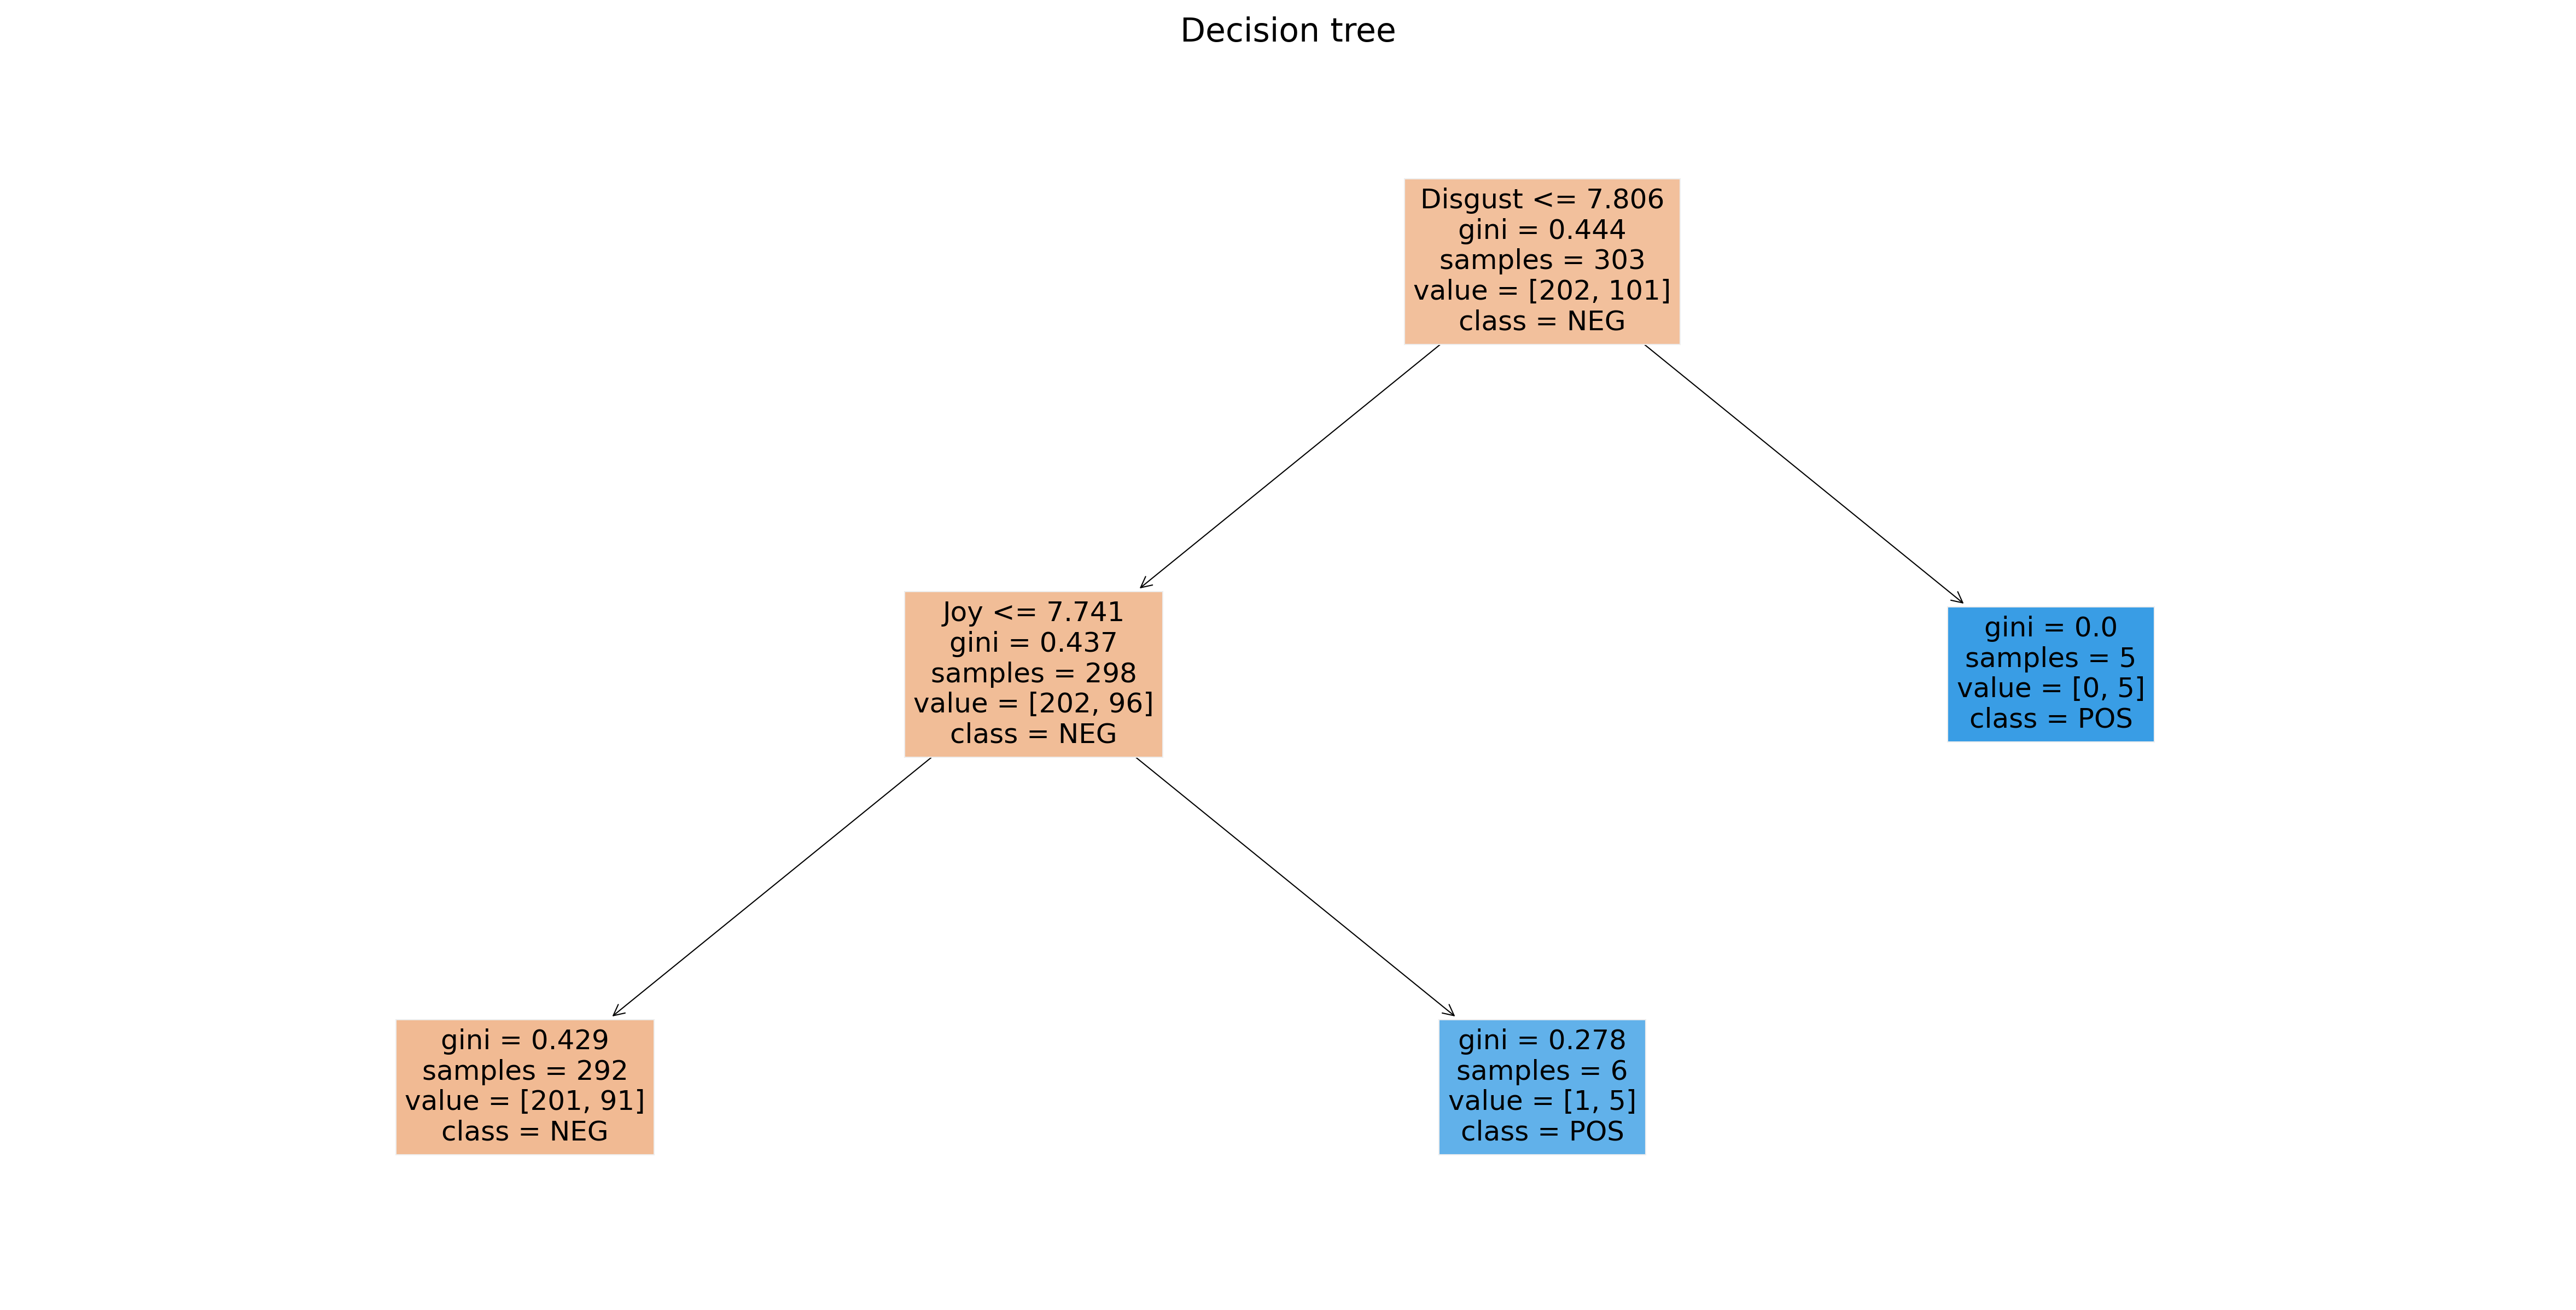

In [31]:
clf = tree.DecisionTreeClassifier(max_leaf_nodes=3) ## max_depth=3
clf = clf.fit(s_train_x, s_train_y)

fig = plt.figure(num=None, figsize=(20, 6), dpi=300, facecolor='w', edgecolor='k')
fig.set_size_inches(20, 10)

tree.plot_tree(clf, feature_names=['Trust', 'Joy', 'Surprise', 'Anticipation', 'Fear', 'Anger', 'Disgust', 'Sadness'], fontsize=12, filled = True, class_names=['NEG', 'POS'])
plt.title("Decision tree")
plt.show()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


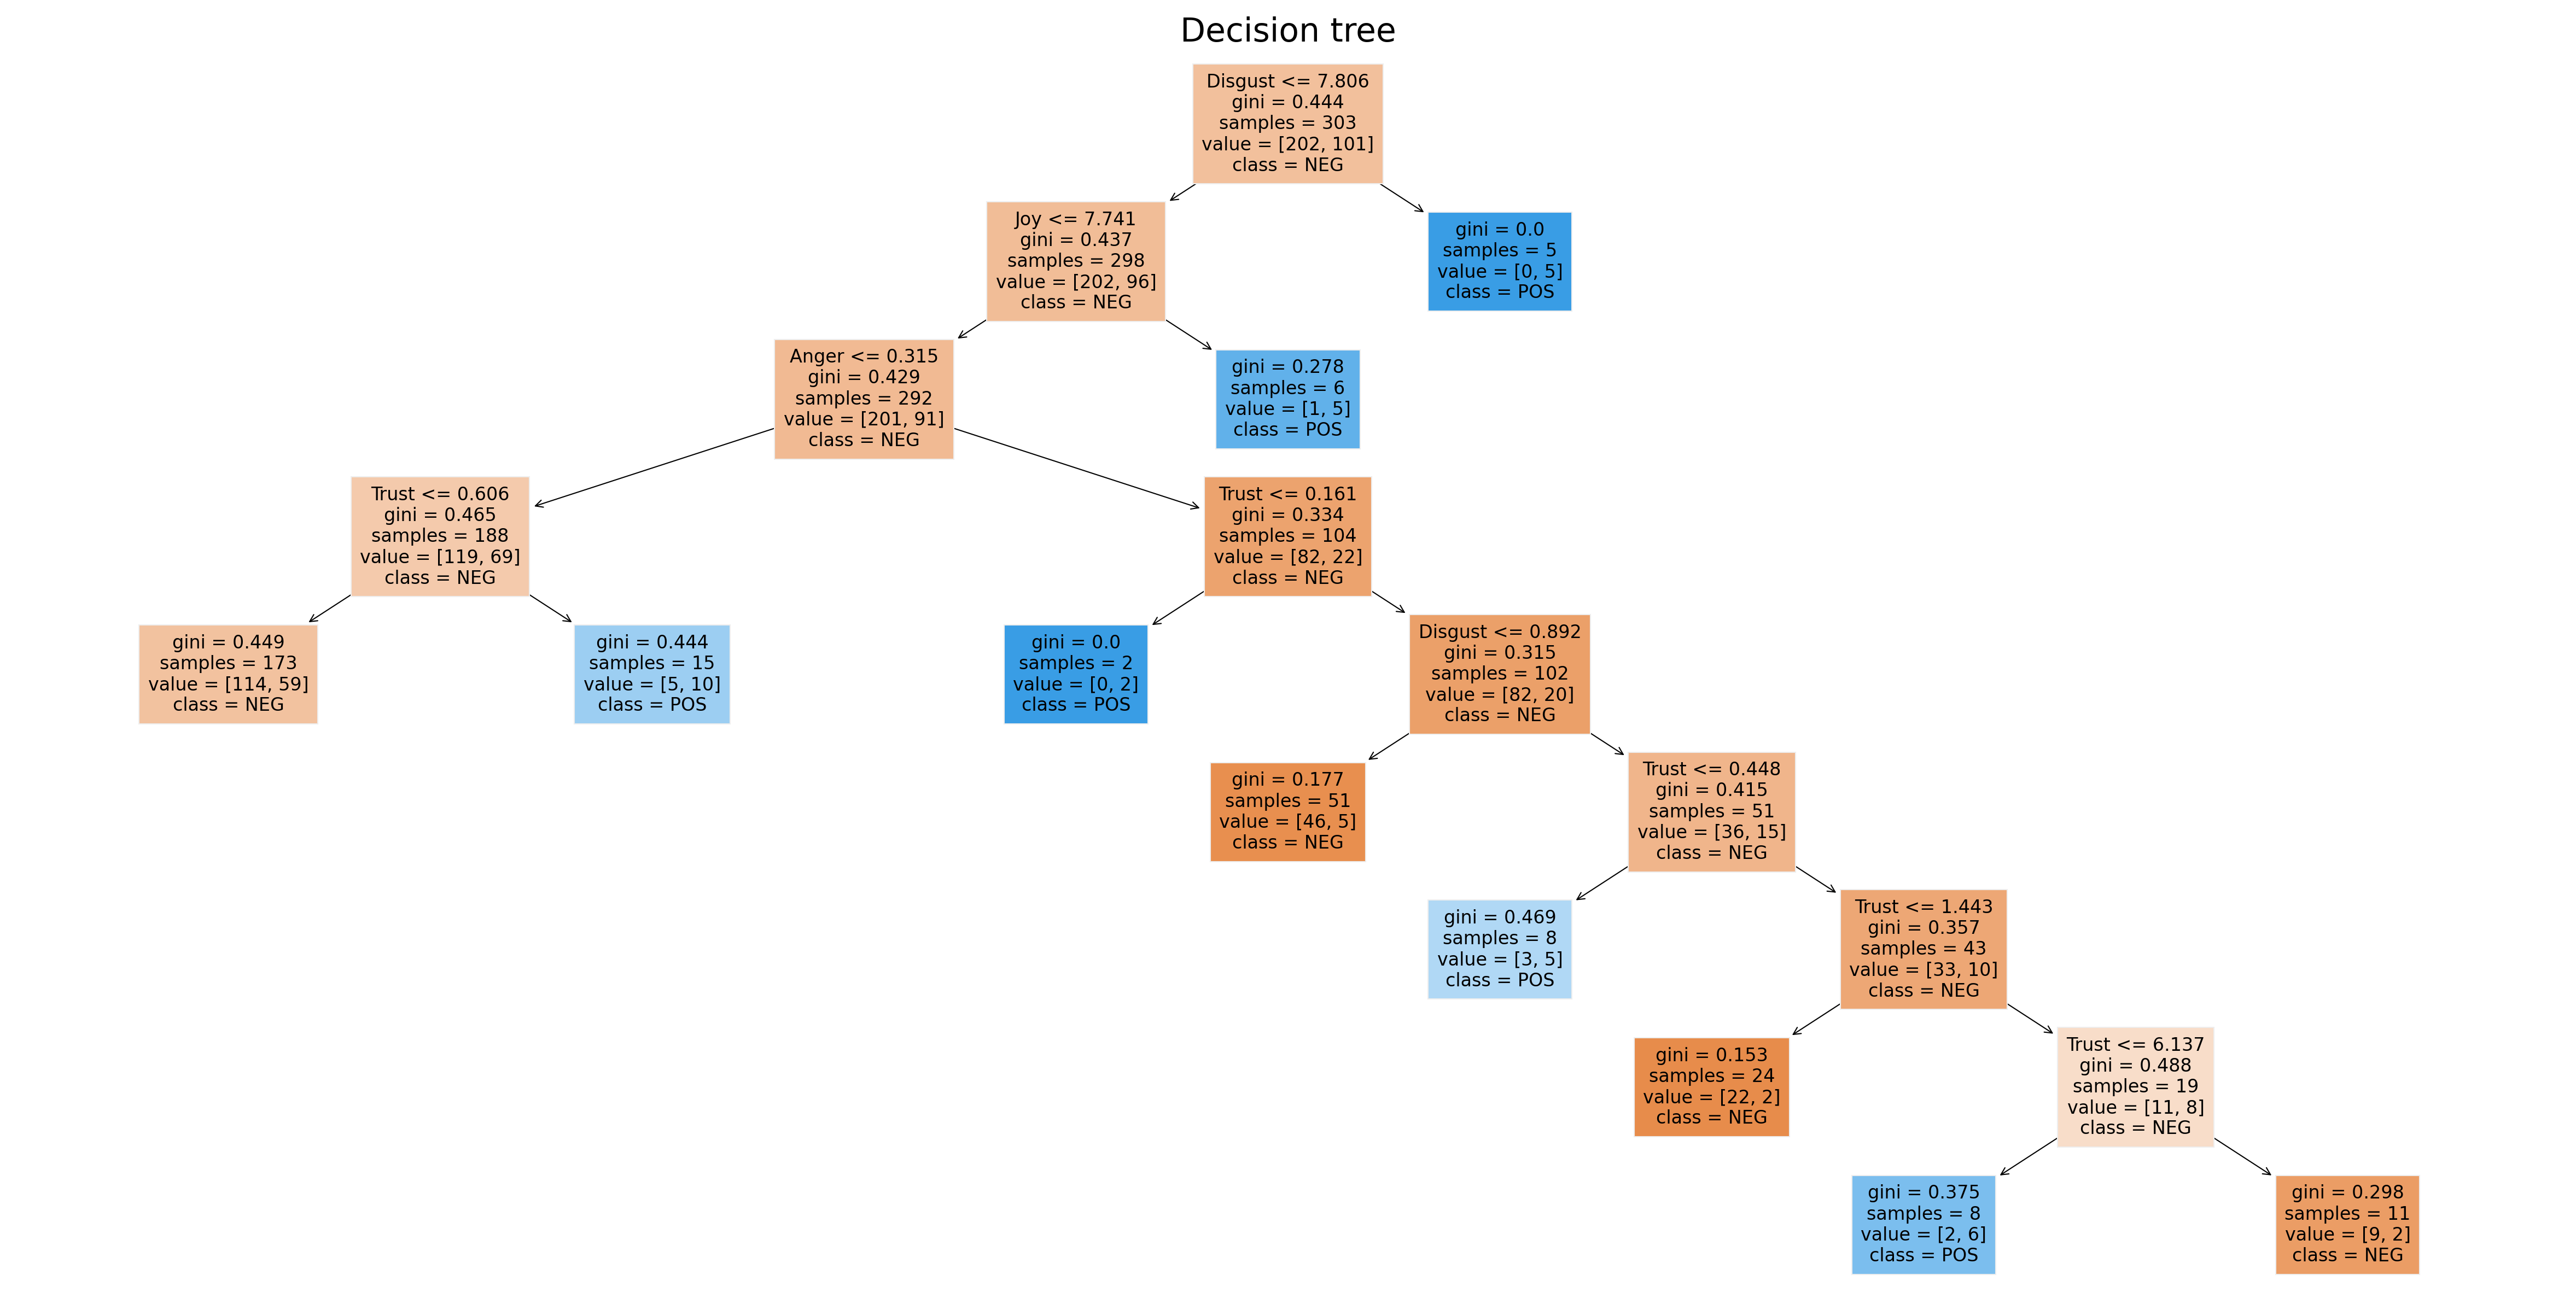

In [32]:
## Classify 10 customer types

clf = tree.DecisionTreeClassifier(max_leaf_nodes=10)
clf = clf.fit(s_train_x, s_train_y)

fig = plt.figure(num=None, figsize=(20, 6), dpi=300, facecolor='w', edgecolor='k')
fig.set_size_inches(20, 10)

tree.plot_tree(clf, feature_names=['Trust', 'Joy', 'Surprise', 'Anticipation', 'Fear', 'Anger', 'Disgust', 'Sadness'], fontsize=8, filled = True, class_names=['NEG', 'POS'])
plt.title("Decision tree")
plt.show()

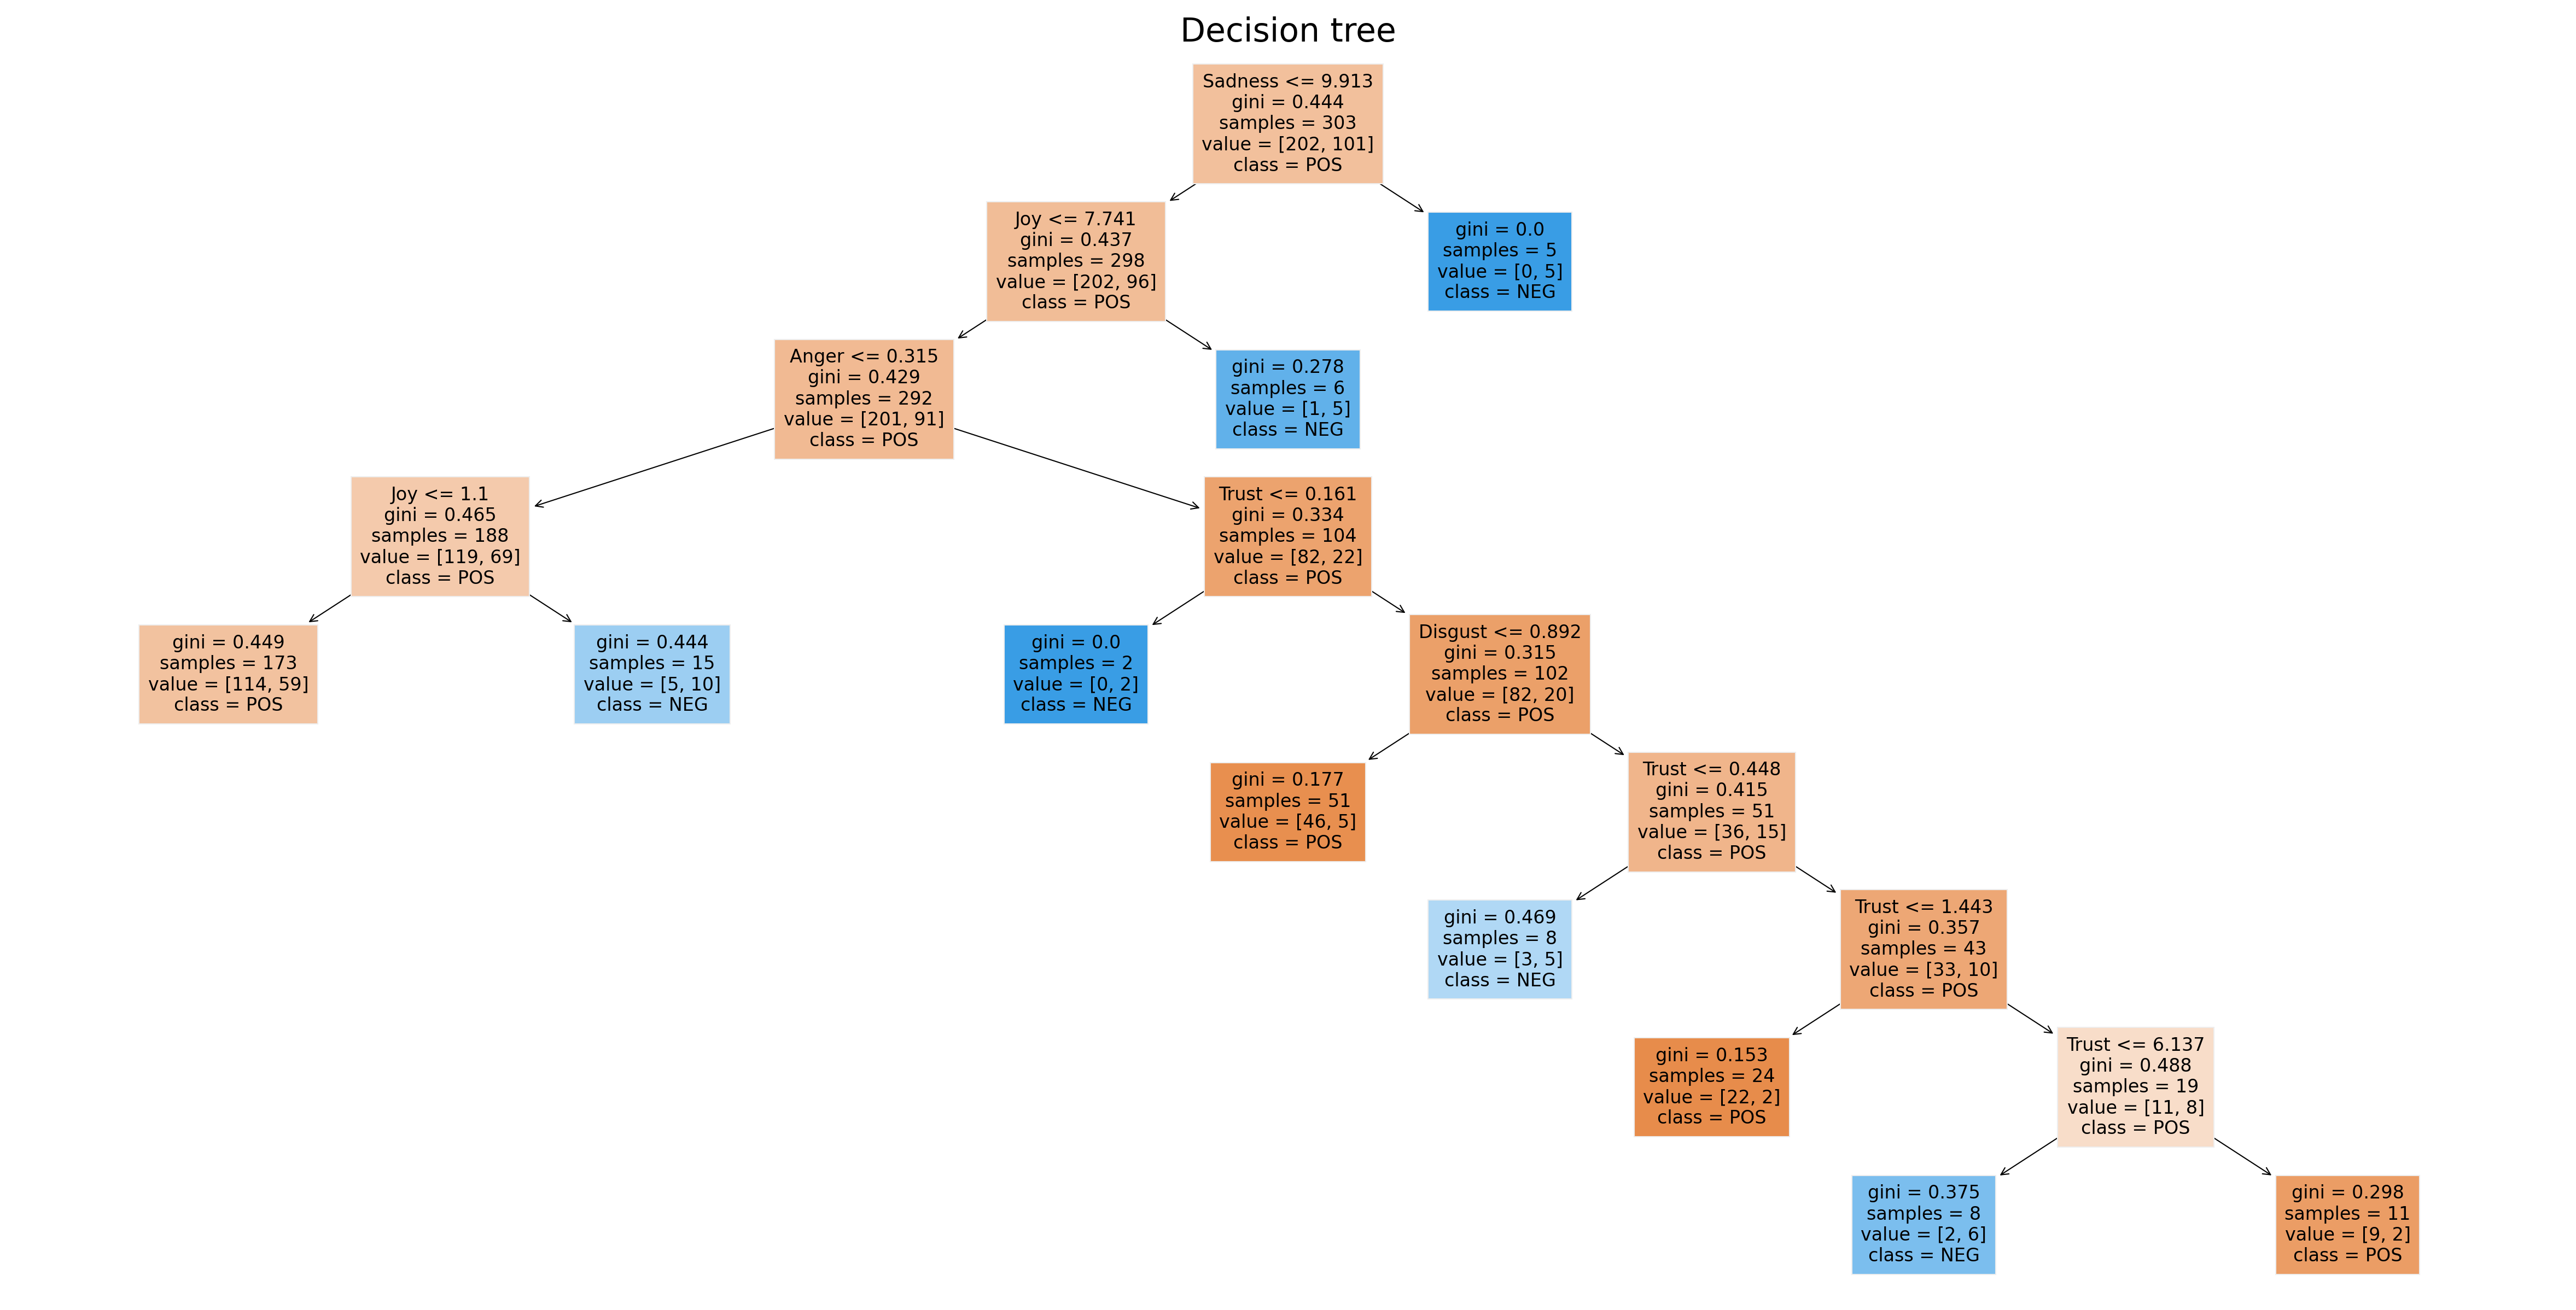

In [33]:
## Classify 10 customer types

clf = tree.DecisionTreeClassifier(max_leaf_nodes=10)
clf = clf.fit(s_train_x, s_train_y)

fig = plt.figure(num=None, figsize=(20, 6), dpi=300, facecolor='w', edgecolor='k')
fig.set_size_inches(20, 10)

tree.plot_tree(clf, feature_names=['Trust', 'Joy', 'Surprise', 'Anticipation', 'Fear', 'Anger', 'Disgust', 'Sadness'], fontsize=8, filled = True, class_names=['POS', 'NEG'])
plt.title("Decision tree")
plt.show()

In [34]:
data_all

,Title,Prediction,NEG,POS,Trust,Joy,Surprise,Anticipation,Fear,Anger,Disgust,Sadness,IS_EXTREME,comments,pos_neg
0,問卦歐美中國舉重同量級無法超越台灣郭婞淳,neg,1,0,0.5238,0.5593,0.5058,0.5397,0.5853,2.4902,12.5000,2.3929,1,13,0
1,新聞世錦賽舉重女神郭婞淳挺舉總和,pos,0,1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,16,1
2,爆卦郭婞淳2021舉重世錦賽挺舉總和金牌,pos,0,1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,143,1
3,問卦郭婞淳國語也太不標準了吧,neg,1,0,0.5320,0.5348,0.2890,0.7107,0.0500,0.2071,0.2502,0.2662,0,69,0
4,問卦如果郭婞淳的故事拍電影讓瑤瑤演可以嗎,pos,0,1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,12,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428,新聞陳其邁暖迎戴資穎讓她吃好睡好小,neg,1,0,2.2016,3.0642,2.0326,0.8954,0.2308,0.4321,0.0990,0.8822,1,191,0
429,問卦戴資穎受訪的時候要問他什麼,neg,1,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,11,0
430,新聞戴資穎深夜罕見動怒被批沒奪金失誤,pos,0,1,0.3760,0.3128,0.4748,0.3327,0.4340,0.4184,0.4360,0.4940,0,303,1
431,新聞戴資穎返台罕見說重話回文站在場上,neg,1,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,30,0


In [35]:
## Generate training data.

from sklearn.model_selection import train_test_split
from sklearn.tree import export_text

s_train_x, s_valid_x, s_train_y, s_valid_y = train_test_split(data_all[['Trust', 'Joy', 'Surprise', 'Anticipation', 'Fear', 'Anger', 'Disgust', 'Sadness']], data_all[['POS', 'NEG']], test_size = 0.3, random_state=42)

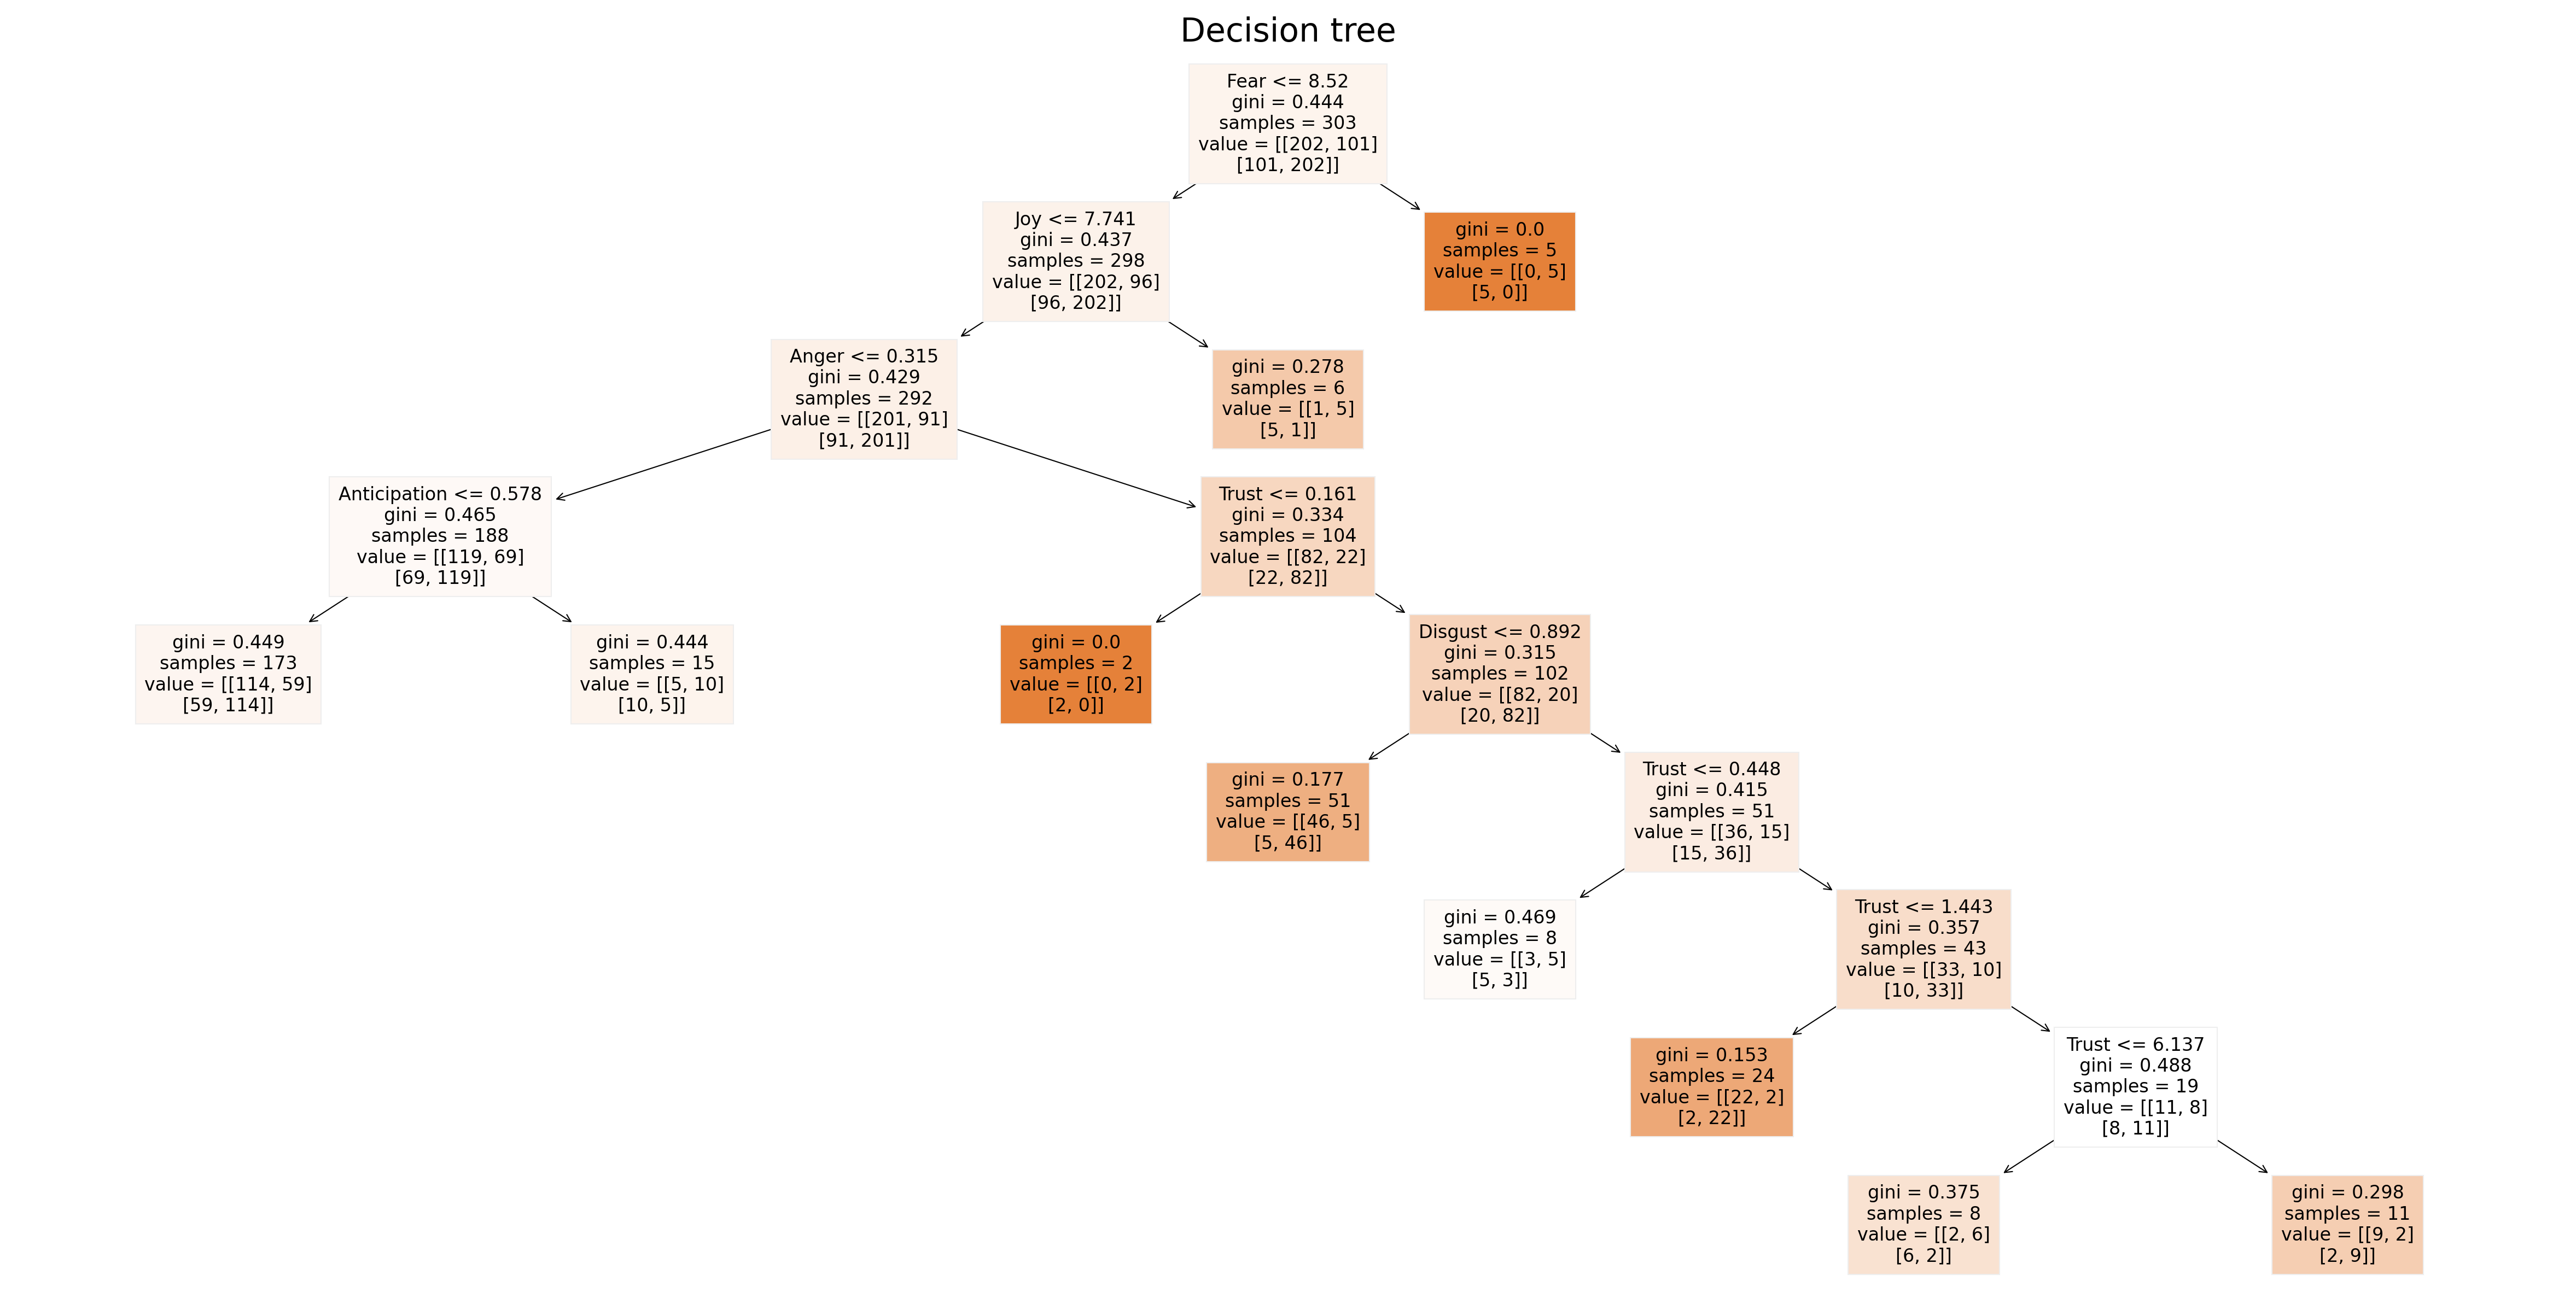

In [36]:
## Classify 10 customer types

clf = tree.DecisionTreeClassifier(max_leaf_nodes=10)
clf = clf.fit(s_train_x, s_train_y)

fig = plt.figure(num=None, figsize=(20, 6), dpi=300, facecolor='w', edgecolor='k')
fig.set_size_inches(20, 10)

tree.plot_tree(clf, feature_names=['Trust', 'Joy', 'Surprise', 'Anticipation', 'Fear', 'Anger', 'Disgust', 'Sadness'], fontsize=8, filled = True, class_names=['POS', 'NEG'])
plt.title("Decision tree")
plt.show()